In [1]:
import tensorflow as tf
import keras as kr
import urllib.request
import os
url="http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls"
filepath="titanic3.xls"
if not os.path.isfile(filepath):
    result=urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)

Using TensorFlow backend.


In [87]:
import numpy
import pandas as pd

all_df = pd.read_excel(filepath)
print(all_df[:2])
print("-"*10)
cols = ['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']
all_df = all_df[cols]
print(all_df[:2])

   PassengerId  pclass  survived                            name     sex  \
0            1       1         1   Allen, Miss. Elisabeth Walton  female   
1            2       1         1  Allison, Master. Hudson Trevor    male   

       age  sibsp  parch  ticket      fare    cabin embarked boat  body  \
0  29.0000      0      0   24160  211.3375       B5        S    2   NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11   NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
----------
   survived                            name  pclass     sex      age  sibsp  \
0         1   Allen, Miss. Elisabeth Walton       1  female  29.0000      0   
1         1  Allison, Master. Hudson Trevor       1    male   0.9167      1   

   parch      fare embarked  
0      0  211.3375        S  
1      2  151.5500        S  


## 資料前處理

In [88]:
df = all_df.drop(['name'],axis=1)
print(all_df.isnull().sum())
print("-"*10)
age_mean = df['age'].mean()
df['age'] = df['age'].fillna(age_mean)
fare_mean = df['fare'].mean()
df['fare'] = df['fare'].fillna(fare_mean)
df['sex'] = df['sex'].map({'female':0,'male':1}).astype(int)
x_OneHot_df = pd.get_dummies(data=df,columns=["embarked"])
print(x_OneHot_df[:2])

survived      0
name          0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64
----------
   survived  pclass  sex      age  sibsp  parch      fare  embarked_C  \
0         1       1    0  29.0000      0      0  211.3375           0   
1         1       1    1   0.9167      1      2  151.5500           0   

   embarked_Q  embarked_S  
0           0           1  
1           0           1  


## 將DataFrame轉換成Array

In [89]:
ndarray = x_OneHot_df.values
print(ndarray.shape)
print("-"*10)
print(ndarray[:2])
label = ndarray[:,0]
Features = ndarray[:,1:]
print("-"*10)
print(label[:2])
print("-"*10)
print(Features[:2])

(1309, 10)
----------
[[  1.       1.       0.      29.       0.       0.     211.3375   0.
    0.       1.    ]
 [  1.       1.       1.       0.9167   1.       2.     151.55     0.
    0.       1.    ]]
----------
[1. 1.]
----------
[[  1.       0.      29.       0.       0.     211.3375   0.       0.
    1.    ]
 [  1.       1.       0.9167   1.       2.     151.55     0.       0.
    1.    ]]


In [90]:
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
scaledFeatures = minmax_scale.fit_transform(Features)
scaledFeatures[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

## 將data分成train和test

In [91]:
msk = numpy.random.rand(len(all_df)) < 0.8
train_df = all_df[msk]
test_df = all_df[~msk]
print(
'total:',len(all_df),
'train:',len(train_df),
'test:',len(test_df)
)
print("-"*10)
def PreprocessData(raw_df):
    df=raw_df.drop(['name'],axis=1)
    age_mean=df['age'].mean()
    df['age']=df['age'].fillna(age_mean)
    fare_mean=df['fare'].mean()
    df['fare']=df['fare'].fillna(fare_mean)
    df['sex']=df['sex'].map({'female':0,'male':1}).astype(int)
    x_OneHot_df=pd.get_dummies(data=df,columns=["embarked"])
    
    ndarray=x_OneHot_df.values
    Feature=ndarray[:,1:]
    Label=ndarray[:,0]
    
    minmax_scale=preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures=minmax_scale.fit_transform(Feature)
    
    return scaledFeatures,Label

train_Features,train_Label=PreprocessData(train_df)
test_Features,test_Label=PreprocessData(test_df)
print(train_Features[:2])
print("-"*10)
print(train_Label[:2])

total: 1309 train: 1028 test: 281
----------
[[0.         0.         0.36116884 0.         0.         0.41250333
  0.         0.         1.        ]
 [0.         1.         0.00939458 0.125      0.22222222 0.2958059
  0.         0.         1.        ]]
----------
[1. 1.]


# Keras：

In [92]:
import urllib.request
import os
import tarfile

## 數據前處理

In [94]:
all_df = pd.read_excel("titanic3-1.xls")
cols=['survived','name','pclass' ,'sex', 'age', 'sibsp',
      'parch', 'fare', 'embarked']
all_df=all_df[cols]
msk = numpy.random.rand(len(all_df)) < 0.8 #8成train、2成test
train_df = all_df[msk]
test_df = all_df[~msk]
print('total:',len(all_df),
      'train:',len(train_df),
      'test:',len(test_df)) #顯示總數量、train數量、test數量

total: 1309 train: 1063 test: 246


In [95]:
train_Features,train_Label=PreprocessData(train_df)
test_Features,test_Label=PreprocessData(test_df)

## 建立模型

In [96]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
model = Sequential() #線性堆疊模型
model.add(Dense(units=40, input_dim=9, 
                kernel_initializer='uniform', 
                activation='relu')) #Dense神經網路層(上一層與下一層的神經元都完全連接)
#units：神經元數
#input_dim：9個神經元輸入
#activation：激活函數relu

In [97]:
model.add(Dense(units=30, 
                kernel_initializer='uniform', 
                activation='relu'))

In [98]:
model.add(Dense(units=1, 
                kernel_initializer='uniform',
                activation='sigmoid'))

## 訓練模型

In [99]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
#compile(source, filename, mode[, flags[, dont_inherit]])
#loss='binary_crossentropy' 損失函數
#optimizer='adam' 優化器
#metrics=['accuracy'] 評估模型方式:準確率
train_history =model.fit(x=train_Features, 
                         y=train_Label, 
                         validation_split=0.1, 
                         epochs=30, 
                         batch_size=30,verbose=2)
#validation_split：9成train、1成test
#epochs：n個訓練週期 
#batch_size：每次執行n個數據
#verbose：顯示訓練過程，0為不在標準輸出流輸出日誌訊息，1為輸出進度條記錄，2為每個epoch輸出一行記錄

#結果解讀：
#loss: (train誤差) - acc: (train準確) - val_loss: (test誤差 )- val_acc: (test準確)

Train on 956 samples, validate on 107 samples
Epoch 1/30
 - 1s - loss: 0.6893 - acc: 0.5764 - val_loss: 0.6619 - val_acc: 0.7850
Epoch 2/30
 - 0s - loss: 0.6573 - acc: 0.5900 - val_loss: 0.5469 - val_acc: 0.7850
Epoch 3/30
 - 0s - loss: 0.6084 - acc: 0.6444 - val_loss: 0.4831 - val_acc: 0.7850
Epoch 4/30
 - 0s - loss: 0.5690 - acc: 0.7270 - val_loss: 0.4557 - val_acc: 0.7944
Epoch 5/30
 - 0s - loss: 0.5316 - acc: 0.7897 - val_loss: 0.4415 - val_acc: 0.8131
Epoch 6/30
 - 0s - loss: 0.5087 - acc: 0.7814 - val_loss: 0.4275 - val_acc: 0.8131
Epoch 7/30
 - 0s - loss: 0.4934 - acc: 0.7814 - val_loss: 0.4238 - val_acc: 0.8131
Epoch 8/30
 - 0s - loss: 0.4864 - acc: 0.7877 - val_loss: 0.4564 - val_acc: 0.8131
Epoch 9/30
 - 0s - loss: 0.4779 - acc: 0.7845 - val_loss: 0.4235 - val_acc: 0.8131
Epoch 10/30
 - 0s - loss: 0.4731 - acc: 0.7866 - val_loss: 0.4268 - val_acc: 0.8131
Epoch 11/30
 - 0s - loss: 0.4701 - acc: 0.7856 - val_loss: 0.4312 - val_acc: 0.8131
Epoch 12/30
 - 0s - loss: 0.4709 - acc:

In [100]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

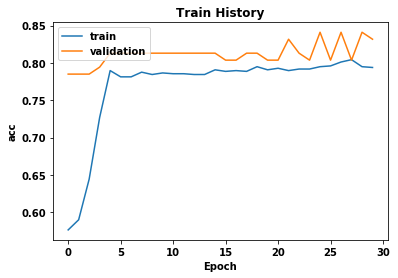

In [101]:
show_train_history(train_history,'acc','val_acc') #準確率執行結果

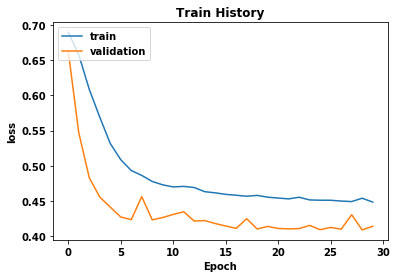

In [102]:
show_train_history(train_history,'loss','val_loss') #誤差率執行結果

## 評估模型準確率

In [103]:
scores = model.evaluate(x=test_Features, 
                        y=test_Label)

246/246 [==============================] - 0s 36us/step


In [104]:
scores[1]

0.7723577216388734

## 加入Jack、Rose數據

In [105]:
Jack = pd.Series([0 ,'Jack',3, 'male'  , 23, 1, 0,  5.0000,'S'])
Rose = pd.Series([1 ,'Rose',1, 'female', 20, 1, 0, 100.0000,'S'])
JR_df = pd.DataFrame([list(Jack),list(Rose)],  
                  columns=['survived', 'name','pclass', 'sex', 
                   'age', 'sibsp','parch', 'fare','embarked'])
all_df=pd.concat([all_df,JR_df])
all_df[-2:] #查看最後兩項新增的數據(J&R)

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


## 進行預測

In [106]:
all_Features,Label=PreprocessData(all_df)
all_probability=model.predict(all_Features) #進行預測
all_probability[:10] #取前10項數據

array([[0.9535768 ],
       [0.569744  ],
       [0.951892  ],
       [0.33720136],
       [0.9423639 ],
       [0.25472277],
       [0.85538125],
       [0.30358294],
       [0.851666  ],
       [0.25856742]], dtype=float32)

In [107]:
pd=all_df
pd.insert(len(all_df.columns),
          'probability',all_probability)

## 預測Jack & Rose資料的生存機率

In [108]:
pd[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.129992
1,1,Rose,1,female,20.0,1,0,100.0,S,0.942932


## 查看生存率高卻沒有存活的旅客

In [109]:
pd[(pd['survived']==0) &  (pd['probability']>0.9) ]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.951892
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.942364
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.960341
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.954074


In [110]:
pd[:5]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S,0.953577
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S,0.569744
2,0,"Allison, Miss. Helen Loraine",1,female,2.0000,1,2,151.5500,S,0.951892
3,0,"Allison, Mr. Hudson Joshua Creighton",1,male,30.0000,1,2,151.5500,S,0.337201
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0000,1,2,151.5500,S,0.942364


# 結論：
這次鐵達尼資料集的目標是預測乘客「**是否生存**」<br>
在各種欄位當中，我們可以觀察到...<br>
1. 名字有可能影響最後生存率：名字**長度**、名字**某個字**的特徵可能與**國籍、民族文化有相關**，導致個性的不同，自然會影響到緊急時刻逃生的急迫性、求生的渴望(搶搭救生艇，還是魚貫排隊搭救生艇)
2. 小孩個數1-3個存活率高：**老弱婦孺優先上救生艇**，大人陪同小孩優先上救生艇，導致整家人存活機率大幅提高
3. 女士存活率高：**Lady First**觀念，優先上救生艇
